# _Vipul Ramakant Pawar_ 
## 03/02/2020

# Battle of Neighborhoods of London and Toronto
#### Additional screenshots for maps are attached in the github, Battle of Neighborhoods Report. As Maps are not rendered by default on github. 

## Introduction

### Background

> - London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. London has a diverse range of people and cultures, and more than 300 languages are spoken in the region. Its estimated mid-2018 municipal population (corresponding to Greater London) was 8,908,081, the most populous of any city in the European Union and accounting for 13.4% of the UK population.
>
>
> - Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 as of 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group, and over 200 distinct ethnic origins are represented among its inhabitants. While the majority of Torontonians speak English as their primary language, over 160 languages are spoken in the city.

### Problem
> - Both the cities are financial capitals of respective countries and are diverse in cultures, as well as these cities have many visitors every year. So, aim of the project is to analyze the similar and dissimilar interests of the people living in both the cities and determine the localities that are popular for some specific venue categories.

### Interested Audience
> - I am a Traveller myself, I like to visit places with significance importance and explore their beauty, these both cities are very popular and have been experiencing increase in visitors overall over years. Those who are planning or interested in visiting these cities might be interested what are good localities and local people interest overall in the both cities.


### Data Sources
> - For our analysis we will require data of neighborhoods of both the cities which I have taken from Wikipedia. We will require attributes such as name of neighborhoods, boroughs, postal codes of the neighborhoods. These all attributes are provided in the form of table in Wikipedia. We will scrape these table using beautiful soup library in python.

## Working on London Neighborhood data from Wikipedia

### Retrieving the London Postal Codes

#### Downloading and importing the package 

In [1]:
!pip install geopy
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install requests
!conda install -c conda-forge geopy --yes 
!pip install requests
!conda install -c conda-forge geocoder --yes 
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

    geocoder: 1.38.1-py_1 conda-forge
    ratelim:  0.1.6-py_2  conda-forge


geocoder-1.38.1      | 53 KB     | ##################################### | 100% 
ratelim-0.1.6        | 6 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Pa

In [7]:
import pandas as pd
import numpy as np
import requests
import csv
import folium
from bs4 import BeautifulSoup
import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


from geopy.geocoders import Nominatim

import requests
import csv
from bs4 import BeautifulSoup

#### Fetching Data for London Neighborhoods from Wikipedia

- Performing operations to achieve a tabular form of the London data.

In [8]:
!wget -q -O 'london.html' https://en.wikipedia.org/wiki/List_of_areas_of_London
print('Data downloaded!')

Data downloaded!


In [9]:

with open('london.html') as html_file:
    soup = BeautifulSoup(html_file,'lxml')
Title = soup.title.text
print(Title)

List of areas of London - Wikipedia


In [10]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
soup = BeautifulSoup(source,'lxml')
#print(soup.prettify())

In [11]:
table = soup.find('table', class_='wikitable sortable')
#print(table.prettify)

In [12]:
text = table.tbody.text
#print(text)

In [13]:
text = text.splitlines()
#print(text)

In [14]:
while("" in text) : 
    text.remove("") 
#print(text)

In [15]:
del text[324:329]
del text[1398:1403]

In [16]:
N=6
subList = [text[n:n+N] for n in range(0, len(text), N)]    
#print(subList)

In [17]:
London = pd.DataFrame(subList,columns=('Neighborhoods','Borough', 'Town','Postcode','Dial Code','OS grid ref'),)
London= London.iloc[1:]

In [18]:
London.shape

(531, 6)

#### Data Cleaning of London Neighborhoods

In [19]:
# Dropping unnecessary columns of Dial_code and OS_grid_ref

London = London.drop("Dial Code", axis=1)
London = London.drop("OS grid ref",axis=1)

In [20]:
# Cleaning the Borough variable
London['Borough'] =  London['Borough'].apply(lambda x: x.replace('[','').replace(']','')) 
London['Borough'] =  London['Borough'].str.replace('\d+', '')

In [21]:
# Counting the town whcih comes under london city
London[London.Town == "LONDON"].shape

(299, 4)

In [22]:
# Sclicing the town to just london
London = London[London.Town == "LONDON"]

In [23]:
# Dropping the column of Town since it's purely London data
London = London.drop("Town", axis=1)

In [24]:
London.head()

,Neighborhoods,Borough,Postcode
1,Abbey Wood,"Bexley, Greenwich",SE2
2,Acton,"Ealing, Hammersmith and Fulham","W3, W4"
7,Aldgate,City,EC3
8,Aldwych,Westminster,WC2
10,Anerley,Bromley,SE20


In [25]:
# checking if the postcode is unique for all teh rows
print("Normal Non Unique shape of dataframe : ",London.Postcode.shape)

print("Unique shape of Postcodes in dataframe : ",London.Postcode.unique().shape)

Normal Non Unique shape of dataframe :  (299,)
Unique shape of Postcodes in dataframe :  (151,)


- We see that we have 151 unique postal code and currently we have 299 neighborhoods
- So, grouping neighborhoods for every unique postal code

In [26]:
London = London.groupby(['Postcode','Borough'])['Neighborhoods'].apply(lambda x: ','.join(x.unique())).reset_index()

In [27]:
London.shape

(183, 3)

- We have 208 unique combinations of lodon Postcode and Borough.

- Now next thing is getting the neighborhood lattitude and longitude coordinates.

### Getting coordinates of individual Places using geocoder

In [28]:
# defining the function for geopy library to get latitude and longitude for all the neighborhoods

def getNeighborhoodLatLong(Postcode,Borough,Neighborhoods):
    
    #Neighborhood with lat , long
    latlang = []
    # defining the user agent for geopy
    geolocator = Nominatim(user_agent="London")
    
    # for every unique combination of Neighborhood and Borough get the lattitude and longitude
    for postcode, borough, neigh in zip(Postcode,Borough,Neighborhoods):
        address = str(postcode +"London, United Kingdom")
        location = geocoder.arcgis(address)
        latlang.append(
        location.latlng
        )
    
    return(latlang)
       

In [29]:
london_neigh = getNeighborhoodLatLong( Postcode = London["Postcode"],
                                      Borough = London["Borough"],
                                      Neighborhoods = London["Neighborhoods"]
)

In [30]:
len(london_neigh)

183

In [31]:
london_neigh

[[53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [51.558850000000064, -0.00732999999996764],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [51.52653000000004, 0.02876000000003387],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [51.54505000000006, -0.05531999999993786],
 [53.40838660500003, -1.9695595439999352],
 [51.53292000000005, 0.05461000000002514],
 [53.408

In [32]:
len(london_neigh)

183

In [33]:
# we got the latitide and longitude for each of the postal code now lets merge it to our neighborhoods

# since our cordinates are combines lets split them into two lists of latitude and longitude.
latitude= []
longitude = []
for lat, lng in london_neigh:
    latitude.append(lat)
    longitude.append(lng)

print(latitude[0:5])
print(longitude[0:5])

[53.40838660500003, 53.40838660500003, 53.40838660500003, 51.558850000000064, 53.40838660500003]
[-1.9695595439999352, -1.9695595439999352, -1.9695595439999352, -0.00732999999996764, -1.9695595439999352]


In [34]:
# We got the latitide and longitude for each of the postal code now lets merge it to our neighborhoods

# Since our cordinates are combines lets split them into two lists of latitude and longitude.
latitude= []
longitude = []
for lat, lng in london_neigh:
    latitude.append(lat)
    longitude.append(lng)

print(latitude[0:5])
print(longitude[0:5])

[53.40838660500003, 53.40838660500003, 53.40838660500003, 51.558850000000064, 53.40838660500003]
[-1.9695595439999352, -1.9695595439999352, -1.9695595439999352, -0.00732999999996764, -1.9695595439999352]


In [35]:
# now that we have got the latitude and logitude lists we can just put them in our dataframe.
London["Latitude"] = latitude
London["Longitude"] = longitude

London.head()

,Postcode,Borough,Neighborhoods,Latitude,Longitude
0,DA5,Dartford,Dartford,53.408387,-1.96956
1,E1,Tower Hamlets,"Mile End,Ratcliff,Shadwell,Spitalfields,Stepne...",53.408387,-1.96956
2,E10,Hackney,Lea Bridge,53.408387,-1.96956
3,"E10, E15",Waltham Forest,Leyton,51.558850,-0.00733
4,E11,Redbridge,Wanstead,53.408387,-1.96956


In [36]:
# now we can plot the neighborhoods on map of london
# but before that we have to get the coordinates of london city! lets do that again using geocoder
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="london_neighborhoods")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


### Mapping coordinates on London

In [37]:
# create map of Lomdon using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10.55)

# add markers to map
for lat, lng, borough, neighborhood in zip(London['Latitude'], London['Longitude'], London['Borough'], London['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
map_london

## Introducing Foursquare to work on London Venues

In [38]:
CLIENT_ID = 'RKWBSTT4NJNIGXG1C3T2EISYFYXKAONXXCLKL0CR4R3G4QSU' # your Foursquare ID
CLIENT_SECRET = 'HSGVYENZ1GYNHSV4FCTDAYMAX4F4LPOCYFTJ5SZQU2CXBZIS' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RKWBSTT4NJNIGXG1C3T2EISYFYXKAONXXCLKL0CR4R3G4QSU
CLIENT_SECRET:HSGVYENZ1GYNHSV4FCTDAYMAX4F4LPOCYFTJ5SZQU2CXBZIS


#### Top 100 venues within the neighborhoods of London for within 500m radius

In [39]:
# Setting a limit for a easier and pliable work on the dataframe

LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([
            (name, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
             v['venue']['location']['lng'],
             v['venue']['categories'][0]['name']) for v in results
        ])

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
        'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'
    ]

    return (nearby_venues)

In [40]:
l_venues = getNearbyVenues(names=London['Neighborhoods'],
                                latitudes=London['Latitude'],
                                longitudes=London['Longitude'])

Dartford
Mile End,Ratcliff,Shadwell,Spitalfields,Stepney,Wapping,Whitechapel
Lea Bridge
Leyton
Wanstead
Snaresbrook
Cann Hall,Leytonstone
Little Ilford,Manor Park
Plaistow
West Ham
Blackwall,Canary Wharf,Cubitt Town,Isle of Dogs,Leamouth,Limehouse,Millwall,Poplar
Maryland,Stratford
Canning Town,Custom House,North Woolwich,Silvertown
Upper Walthamstow,Walthamstow,Walthamstow Village
South Woodford
Haggerston
Bethnal Green,Cambridge Heath
Bow,Bromley (also Bromley-by-Bow),Old Ford
Chingford,Highams Park
Lower Clapton,Upper Clapton
Hackney
East Ham
Upton Park
Forest Gate
Dalston,Hackney Central
Shacklewell
Hackney Marshes,Hackney Wick,Homerton,South Hackney
Barbican
Clerkenwell,Finsbury,St Luke's
Farringdon
Angel
Aldgate
Tower Hill
Blackfriars
Temple
Woodford
Hoxton,Shoreditch
Barnsbury,Canonbury,De Beauvoir Town,Islington,Pentonville
Fortis Green
Muswell Hill
Brunswick Park,Friern Barnet,New Southgate
Colney Hatch
Arnos Grove
Bounds Green
North Finchley,Woodside Park
Palmers Green
Osidge

#### Size of the resulting dataframe

In [41]:
# Shape of the acquired Dataframe
print(l_venues.shape)
l_venues.head()

(1497, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Leyton,51.55885,-0.00733,Leyton Technical,51.558781,-0.007328,Pub
1,Leyton,51.55885,-0.00733,Oceano Restaurant,51.561250,-0.010059,Mediterranean Restaurant
2,Leyton,51.55885,-0.00733,Coronation Gardens,51.559517,-0.010643,Park
3,Leyton,51.55885,-0.00733,Leyton Orient Supporters Club,51.559931,-0.013497,Sports Bar
4,Leyton,51.55885,-0.00733,Deeney's Café,51.562088,-0.010269,Café


### Generating a word cloud for getting the most popular venue categories in all the neighborhoods in London.

In [42]:
London_venue_categories = " ".join(
    venue for venue in l_venues["Venue Category"])
print("There are {} words in the combination of all review.".format(
    len(London_venue_categories)))

There are 18542 words in the combination of all review.


### Making use of the Word Cloud to better visualize the Popular venues

In [ ]:
from sklearn.cluster import KMeans
from PIL import Image
!conda install -c conda-forge wordcloud==1.4.1 --yes
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: - 

In [ ]:
import matplotlib.pyplot as plt

In [46]:

#Defiing the function for generating wordcloud
def generate_word_cloud(string):
    wordcloud = WordCloud(width=800, height=400,background_color="white").generate(string)
    fig= plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

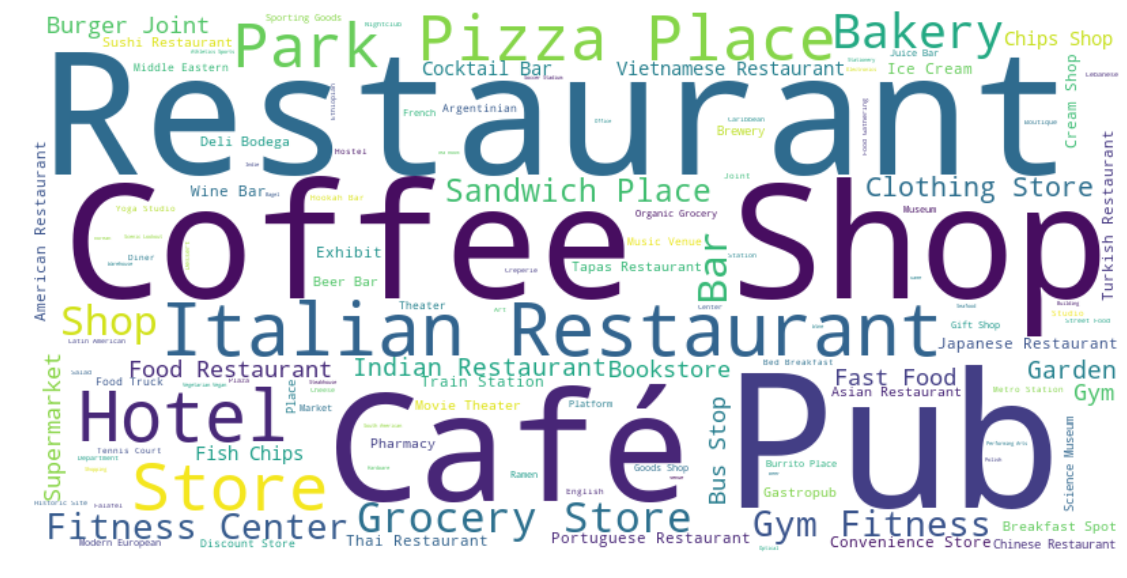

In [47]:
generate_word_cloud(London_venue_categories)

- From Wordcoud we can see that Italian Restaurant, CAfe,Pub,Coffee Shop, Stores, Pizaa are most popular venue categories

### Checking the size of london_venues we just got values for 43 unique neighborhoods insead of 183 neighborhoods

In [48]:
l_venues["Neighborhood"].value_counts().count()

43

In [55]:
London["Neighborhoods"].value_counts().count()

43

### So we will just keep data of 43 neighborhoods for incoorporating foursqure api data 

In [56]:
London = London.loc[
    London["Neighborhoods"].isin(l_venues["Neighborhood"])]
London["Neighborhoods"].value_counts().count()

43

### Now for further analysis we just have those neighborhoods which we have some venue data.

#### Let's check how many venues were returned for each neighborhood

In [57]:
l_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acton,8,8,8,8,8,8
Angel,80,80,80,80,80,80
Arnos Grove,8,8,8,8,8,8
Blackheath Royal Standard,2,2,2,2,2,2
Bounds Green,8,8,8,8,8,8
Brent Cross,6,6,6,6,6,6
Brixton,10,10,10,10,10,10
Colney Hatch,8,8,8,8,8,8
Crystal Palace,25,25,25,25,25,25


### Let's find out how many unique categories can be curated from all the returned venues

In [58]:
print('There are {} uniques categories.'.format(len(l_venues['Venue Category'].unique())))

There are 218 uniques categories.


## Analyze Each Neighborhood using k-means clustering¶

### For analysis using k means clustering we have to convert these venues categories into numerical form using dummies(one hot encoding)

In [59]:
# one hot encoding
london_onehot = pd.get_dummies(l_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = l_venues['Neighborhood'] 

london_onehot.head()

,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Leyton
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Leyton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Leyton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Leyton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Leyton


In [60]:
london_onehot.shape

(1497, 219)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Acton,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Angel,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037500,0.000000,0.000000,0.012500,0.000000,0.000000,0.000000,0.025000
2,Arnos Grove,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Blackheath Royal Standard,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bounds Green,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Brent Cross,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Brixton,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Colney Hatch,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Crystal Palace,0.04,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Ealing,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.011494,0.000000,...,0.000000,0.011494,0.022989,0.011494,0.000000,0.011494,0.000000,0.000000,0.000000,0.000000


In [62]:
#### Let's confirm the new size
london_grouped.shape

(43, 219)

### Let's print each neighborhood along with the top 5 most common venues

In [63]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acton----
               venue  freq
0    Bed & Breakfast  0.12
1  Indian Restaurant  0.12
2      Grocery Store  0.12
3     Breakfast Spot  0.12
4               Park  0.12


----Angel----
         venue  freq
0          Pub  0.09
1  Coffee Shop  0.08
2   Food Truck  0.06
3         Café  0.05
4        Hotel  0.05


----Arnos Grove----
               venue  freq
0      Grocery Store  0.25
1           Bus Stop  0.12
2      Train Station  0.12
3  Convenience Store  0.12
4  Fish & Chips Shop  0.12


----Blackheath Royal Standard----
                venue  freq
0                 Pub   0.5
1  Photography Studio   0.5
2  African Restaurant   0.0
3            Pie Shop   0.0
4        Noodle House   0.0


----Bounds Green----
               venue  freq
0      Grocery Store  0.25
1           Bus Stop  0.12
2      Train Station  0.12
3  Convenience Store  0.12
4  Fish & Chips Shop  0.12


----Brent Cross----
                  venue  freq
0           Music Venue  0.17
1            Hookah Bar  0.

### Let's put that into a pandas dataframe
#### First, let's write a function to sort the venues in descending order.

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']


for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Gas Station,Breakfast Spot,Grocery Store,Park,Convenience Store,Bed & Breakfast,Train Station,Indian Restaurant,Food Stand,Food Truck
1,Angel,Pub,Coffee Shop,Food Truck,Italian Restaurant,Café,Hotel,Vietnamese Restaurant,Gym / Fitness Center,Park,Sushi Restaurant
2,Arnos Grove,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Convenience Store,Beer Bar,Gym,Fried Chicken Joint,French Restaurant,Food Truck
3,Blackheath Royal Standard,Photography Studio,Pub,Yoga Studio,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food & Drink Shop,Flower Shop,Flea Market
4,Bounds Green,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Convenience Store,Beer Bar,Gym,Fried Chicken Joint,French Restaurant,Food Truck


## Clustering Neighborhoods
### Run k-means to cluster the neighborhood into 5 clusters.

In [66]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 4, 2, 4, 3, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int32)

In [67]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = London

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhoods')

london_merged.head() # check the last columns!

,Postcode,Borough,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"E10, E15",Waltham Forest,Leyton,51.55885,-0.00733,1,Fast Food Restaurant,Platform,Gym / Fitness Center,Fried Chicken Joint,Café,Grocery Store,Coffee Shop,Clothing Store,Pub,Sandwich Place
9,"E13, E15",Newham,West Ham,51.52653,0.02876,0,Café,Bus Station,Park,Gym,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand
20,"E5, E8, E9, N1, N16",Hackney,Hackney,51.54505,-0.05532,1,Pub,Café,Coffee Shop,Cocktail Bar,Bakery,Clothing Store,Brewery,Hotel,Grocery Store,Bar
22,"E6, E13",Newham,Upton Park,51.53292,0.05461,1,Pub,Fast Food Restaurant,Bakery,Clothing Store,Coffee Shop,Park,Gym Pool,Optical Shop,Grocery Store,Electronics Store
25,"E8, N16",Hackney,Shacklewell,51.54505,-0.05532,1,Pub,Café,Coffee Shop,Cocktail Bar,Bakery,Clothing Store,Brewery,Hotel,Grocery Store,Bar


### Plotting Neighborhoods into 5 Clusters

In [69]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhoods'], london_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster + 1) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining London city Clusters

In [70]:
# Deciding names for clustering using barcharts
tmp = london_merged.groupby("Cluster Labels")["1st Most Common Venue"]
fig = plt.figure(figsize=(10,4))
colormap = cm.rainbow(np.linspace(0, 1, pop_toronto_venues.shape[0]))
plt.title("Busiest Venues of London per culster")
tmp.value_counts().plot.bar(color = colormap)

NameError: name 'pop_toronto_venues' is not defined

<Figure size 720x288 with 0 Axes>

### Cluster 1
#### Just making a seprate data frames for each cluster which will help us in further analysis

In [71]:
clus1 = london_merged.loc[
    london_merged['Cluster Labels'] == 0,
    london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Newham,0,Café,Bus Station,Park,Gym,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand
49,Hackney,0,Grocery Store,Pub,Coffee Shop,Metro Station,Café,Park,Train Station,Caribbean Restaurant,Bus Stop,Pizza Place
50,Haringey,0,Grocery Store,Pub,Coffee Shop,Metro Station,Café,Park,Train Station,Caribbean Restaurant,Bus Stop,Pizza Place
147,Lambeth,0,Pub,Park,Indian Restaurant,Restaurant,Bike Shop,Bakery,Portuguese Restaurant,Caribbean Restaurant,Yoga Studio,Fish Market
168,"Ealing, Hammersmith and Fulham",0,Gas Station,Breakfast Spot,Grocery Store,Park,Convenience Store,Bed & Breakfast,Train Station,Indian Restaurant,Food Stand,Food Truck


In [72]:
# for popups in map assigning the lists
dft_tmp_clus1 = pd.DataFrame(
    clus1.groupby("Borough")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus1.rename(columns={
    'Borough': 'boroughs',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus1["top_venues"].values

array(['Gas Station', 'Grocery Store', 'Grocery Store', 'Pub', 'Café'],
      dtype=object)

### As observed, the cluster is celebrate for 'Train Station', 'Pub', 'Park' and 'Cafe' categories

### Cluster 2

In [73]:
clus2 = london_merged.loc[
    london_merged['Cluster Labels'] == 1,
    london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus2.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Waltham Forest,1,Fast Food Restaurant,Platform,Gym / Fitness Center,Fried Chicken Joint,Café,Grocery Store,Coffee Shop,Clothing Store,Pub,Sandwich Place
20,Hackney,1,Pub,Café,Coffee Shop,Cocktail Bar,Bakery,Clothing Store,Brewery,Hotel,Grocery Store,Bar
22,Newham,1,Pub,Fast Food Restaurant,Bakery,Clothing Store,Coffee Shop,Park,Gym Pool,Optical Shop,Grocery Store,Electronics Store
25,Hackney,1,Pub,Café,Coffee Shop,Cocktail Bar,Bakery,Clothing Store,Brewery,Hotel,Grocery Store,Bar
30,Islington,1,Pub,Coffee Shop,Food Truck,Italian Restaurant,Café,Hotel,Vietnamese Restaurant,Gym / Fitness Center,Park,Sushi Restaurant


In [74]:
# for popups in map assigning the lists
dft_tmp_clus2 = pd.DataFrame(
    clus2.groupby("Borough")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus2.rename(columns={
    'Borough': 'boroughs',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus2["top_venues"].values

array(['Turkish Restaurant', 'Grocery Store', 'Coffee Shop',
       'Pub,Italian Restaurant', 'Italian Restaurant', 'Coffee Shop',
       'Indian Restaurant', 'Pub', 'Hotel', 'Pub', 'Café',
       'Hotel,Exhibit,Café,Italian Restaurant',
       'Coffee Shop,Café,Portuguese Restaurant', 'Convenience Store',
       'Restaurant', 'Pub', 'Pub', 'Supermarket', 'Pub',
       'Fast Food Restaurant', 'Coffee Shop', 'Coffee Shop'], dtype=object)

### After discrening we conclude that the famed categories within the 2nd cluter are 'Restaurants', 'Pubs', 'Stores' and 'Cafes'

### Cluster 3

In [75]:
clus3 = london_merged.loc[
    london_merged['Cluster Labels'] == 2,
    london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus3.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
123,Greenwich,2,Photography Studio,Pub,Yoga Studio,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food & Drink Shop,Flower Shop,Flea Market


In [76]:
# for popups in map assigning the lists
dft_tmp_clus3 = pd.DataFrame(
    clus3.groupby("Borough")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus3.rename(columns={
    'Borough': 'boroughs',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus3["top_venues"].values


array(['Photography Studio'], dtype=object)

### Cluster 3 is mainly known for 'Photography Studio'

### Cluster 4

In [77]:
clus4 = london_merged.loc[
    london_merged['Cluster Labels'] == 3,
    london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus4.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Brent,3,Supermarket,Historic Site,Gym / Fitness Center,Music Venue,Hookah Bar,Clothing Store,Food Stand,Food & Drink Shop,Flower Shop,Farmers Market
80,Barnet,3,Supermarket,Historic Site,Gym / Fitness Center,Music Venue,Hookah Bar,Clothing Store,Food Stand,Food & Drink Shop,Flower Shop,Farmers Market


In [78]:
# for popups in map assigning the lists
dft_tmp_clus4 = pd.DataFrame(
    clus4.groupby("Borough")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus4.rename(columns={
    'Borough': 'boroughs',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus4["top_venues"].values

array(['Supermarket', 'Supermarket'], dtype=object)

### The source of foot traffic in Cluster 4 is 'Gym/ Fitness Center'

### Cluster 5

In [79]:
clus5 = london_merged.loc[
    london_merged['Cluster Labels'] == 4,
    london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus5.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Barnet,4,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Convenience Store,Beer Bar,Gym,Fried Chicken Joint,French Restaurant,Food Truck
42,Enfield,4,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Convenience Store,Beer Bar,Gym,Fried Chicken Joint,French Restaurant,Food Truck
43,Haringey,4,Grocery Store,Fish & Chips Shop,Train Station,Bus Stop,Convenience Store,Beer Bar,Gym,Fried Chicken Joint,French Restaurant,Food Truck


In [80]:
# for popups in map assigning the lists
dft_tmp_clus5 = pd.DataFrame(
    clus5.groupby("Borough")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus5.rename(columns={
    'Borough': 'boroughs',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus5["top_venues"].values

array(['Grocery Store', 'Grocery Store', 'Grocery Store'], dtype=object)

### The 5th cluster is famous for 'Grocery Stores'

In [81]:
# Map the Clusters for better understanding

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#folium.GeoJson(lon_json).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_spot, borough in zip(
        london_merged['Latitude'], london_merged['Longitude'],
        london_merged['Neighborhoods'], london_merged['Cluster Labels'],
        london_merged['1st Most Common Venue'], london_merged['Borough']):
    # putting the extra options to explore in each cluster on the popups
    if cluster == 0:
        label = folium.Popup("<h6> <center> Bus Stations </center></h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(
            str(poi), str(top_spot), str(borough),
            str(dft_tmp_clus1.loc[dft_tmp_clus1.boroughs == borough,
                                  "top_venues"].values)),
                             parse_html=False)
    elif cluster == 1:
        label = folium.Popup("<center>Pubs </center>\
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(
            str(poi), str(top_spot), str(borough),
            str(dft_tmp_clus2.loc[dft_tmp_clus2.boroughs == borough,
                                  "top_venues"].values)),
                             parse_html=False)

    elif cluster == 2:
        label = folium.Popup("<h6> <center> Pubs </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(
            str(poi), str(top_spot), str(borough),
            str(dft_tmp_clus3.loc[dft_tmp_clus3.boroughs == borough,
                                  "top_venues"].values)),
                             parse_html=False)

    elif cluster == 3:
        label = folium.Popup("<h6> <center> Grocery Stores </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(
            str(poi), str(top_spot), str(borough),
            str(dft_tmp_clus4.loc[dft_tmp_clus4.boroughs == borough,
                                  "top_venues"].values)),
                             parse_html=False)

    elif cluster == 4:
        label = folium.Popup("<h6> <center>Super Market </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(
            str(poi), str(top_spot), str(borough),
            str(dft_tmp_clus5.loc[dft_tmp_clus5.boroughs == borough,
                                  "top_venues"].values)),
                             parse_html=False)

    folium.CircleMarker([lat, lon],
                        radius=7,
                        popup=label,
                        color=rainbow[cluster - 1],
                        fill=True,
                        fill_color=rainbow[cluster - 1],
                        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## Results of London Analysis:
### The following are the highlights of the 5 clusters above:

> - if someone is deciding to buy a house in London we can see the neighborhood clusters venues and based on venues decide where he should buy the house basically analysing the locality.
> - if he is party animal he should go for cluster1 i.e Hackney and Haringey area.
> - if he wants to have coffee's, food at restaurants and pubs nearby he should go for cluster 2 area's.
> - cluster 3 is just for pubs.
> - if he has travelling as his prefrence then public transit is famous in cluster 4 area's.
> - if he is not fan of outdoor eats then he needs groceries a lot and cluster 5 has popular grocerey stores.

### xxxxxxxxxxxxxxxxxxxxxx  End of London Analysis  xxxxxxxxxxxxxxxxxxxxxxxxx

## Working on Toronto Neighbordhood data from Wikipedia 

###  Retrieving the Toronto Postal Codes

- Scrapping the toronto neighbourhood data from wiki using beautiful soup

In [82]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
tb = soup.find('table', class_='wikitable')
table_tmp = tb.tbody.find_all("tr")

In [83]:
headings = []
for th in table_tmp[0].find_all("th"):
    # remove any newlines and extra spaces from left and right
    headings.append(th.text.replace('\n', ' ').strip())

print(headings)

['Postcode', 'Borough', 'Neighbourhood']


### We got the headings now we can operate data in dictionary and then convert it to dataframe

In [84]:
# Converting the raw data into a Tabular format consisting of 3 variables
table_data = []
for tr in tb.tbody.find_all("tr"): # find all tr's from table's tbody
        t_row = {}
        
        for td, th in zip(tr.find_all("td"), headings): 
            t_row[th] = td.text.replace('\n', '').strip()
        table_data.append(t_row)

In [85]:
postcode = []
borough =[] 
neighbourhood = []

for item in table_data[1:]:
    postcode.append(item['Postcode'])
    borough.append(item['Borough'])
    neighbourhood.append(item['Neighbourhood'])

- converted to 3 seprate list checked each list has same length.

In [86]:
print(neighbourhood[:5] , postcode[:5] , borough[:5])

['Not assigned', 'Not assigned', 'Parkwoods', 'Victoria Village', 'Harbourfront'] ['M1A', 'M2A', 'M3A', 'M4A', 'M5A'] ['Not assigned', 'Not assigned', 'North York', 'North York', 'Downtown Toronto']


### Built the Data Frame from the previously acquired data 

In [87]:
Toronto = pd.DataFrame({"PostalCode" : postcode,
              "Borough" :borough,
              "Neighborhood" :neighbourhood})
Toronto.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Clean up the Toronto Dataframe by eliminatig Boroughs with Not assigned values

In [88]:
Toronto = Toronto[Toronto.Borough != "Not assigned"]

In [89]:
Toronto.shape

(210, 3)

### Finding the rows that have neighborhood not assigned

In [90]:
Toronto[Toronto.Neighborhood ==  "Not assigned"]

,PostalCode,Borough,Neighborhood


- Found which rows have not assigned neighborhood

### Converting those non assigned neighborhood values to default vales of borough

In [91]:
Toronto.loc[Toronto.Neighborhood ==  "Not assigned","Neighborhood"] = Toronto["Borough"]

### Grouped unique postal codes with neighbourhood.

In [92]:
Toronto = Toronto.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x.unique())).reset_index()
Toronto.head(20)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


## Getting the coordinates of Neighbordhoods

### Making use of readly available coordinates 

In [93]:
#Loading the data for coordinates of different borough within toronto

!wget -q -O 'locations.csv' http://cocl.us/Geospatial_data
locations = pd.read_csv('locations.csv')
locations = pd.DataFrame(locations)
locations.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [94]:
#Merging the 2 tables

Toronto = pd.merge(right=locations,left=Toronto, right_on='Postal Code', left_on='PostalCode')
Toronto

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",M1K,43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",M1L,43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",M1M,43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",M1N,43.692657,-79.264848


In [95]:
# Droping the unnecessary extra Postal Code
Toronto = Toronto.drop("Postal Code",axis =1)

In [96]:
Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Exploring the Neighborhoods Using Foursquare

In [97]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


- Got the necessary coordinates of Toronto City

In [98]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### In a way to simplifly the analysis we'll only work with Boroughs in the Central Toronto

In [99]:
Toronto = Toronto[Toronto['Borough'].str.contains('Toronto', regex=False)].reset_index(drop=True)
Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [100]:
Toronto["Borough"].unique()

array(['East Toronto', 'Central Toronto', 'Downtown Toronto',
       'West Toronto'], dtype=object)

### Since our data is just focused around Central Toronto getting coordinates using Foursquare api for this location

In [101]:
address = 'Central Toronto,Toronto'

geolocator = Nominatim(user_agent="tn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Central Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Central Toronto are 43.653963, -79.387207.


In [102]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto


## Introducing FourSquare 

### Extracting information on the venues in Central Toronto
#### Inserting the credentials for Foursquare API

In [103]:
#Getting started with the FourSquare by inserting all of the credentials

CLIENT_ID = 'RKWBSTT4NJNIGXG1C3T2EISYFYXKAONXXCLKL0CR4R3G4QSU' # your Foursquare ID
CLIENT_SECRET = 'HSGVYENZ1GYNHSV4FCTDAYMAX4F4LPOCYFTJ5SZQU2CXBZIS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RKWBSTT4NJNIGXG1C3T2EISYFYXKAONXXCLKL0CR4R3G4QSU
CLIENT_SECRET:HSGVYENZ1GYNHSV4FCTDAYMAX4F4LPOCYFTJ5SZQU2CXBZIS


### Investigating Neighborhoods in Toronto
#### Lets get the top 100 venues in this area with their categories within 500m radius

In [104]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [105]:
toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvalles
Runnymede

### Size of the Dataframe

In [106]:
print(toronto_venues.shape)


(1729, 7)


### Number of venues returned on the basis of each neighborhood

In [107]:
#Counting down the categories within each neighborhood

toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton,Exhibition Place,Parkdale Village",24,24,24,24,24,24
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",18,18,18,18,18,18
"Cabbagetown,St. James Town",42,42,42,42,42,42
Central Bay Street,80,80,80,80,80,80
"Chinatown,Grange Park,Kensington Market",90,90,90,90,90,90
Christie,18,18,18,18,18,18


In [108]:
# To get the unique categories within the toronto venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 236 uniques categories.


### Plotting the Busiest Neighborhoods within Toronto

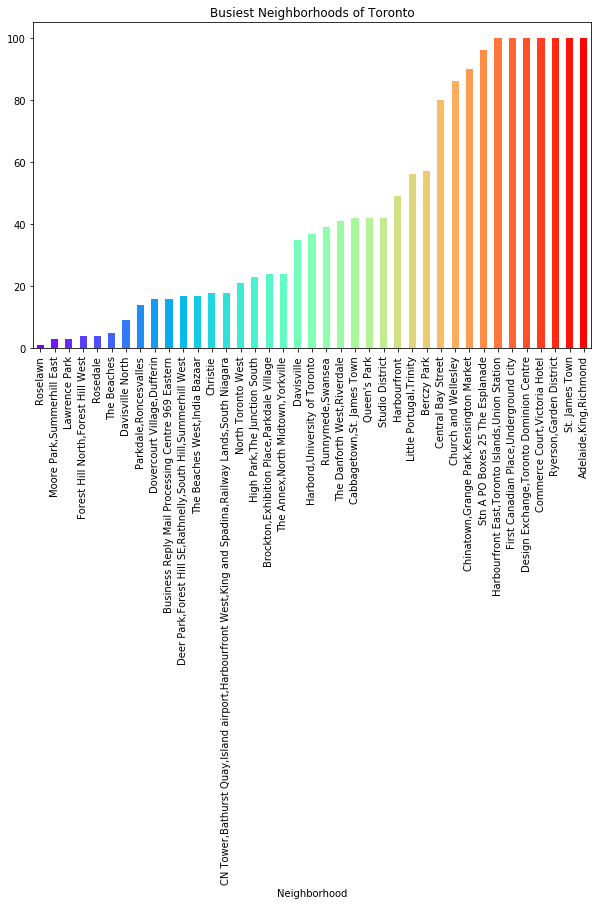

In [109]:

# getting the popular neighborhoods based on count of venues received from foursquare
import matplotlib.pyplot as plt

pop_toronto_venues = toronto_venues.groupby('Neighborhood').count()

import matplotlib.cm as cm
import matplotlib.colors as colors



fig = plt.figure(figsize=(10,6))

colormap = cm.rainbow(np.linspace(0, 1, pop_toronto_venues.shape[0]))
plt.title("Busiest Neighborhoods of Toronto")
ax = pop_toronto_venues["Venue Category"].sort_values().plot.bar(color = colormap)

## Analyze Each Neighborhood

#### For analysis using k means clustering we have to convert these venues categories into numerical form using dummies(one hot encoding)

In [110]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [111]:
# Calculating the mean of categories within each Neighborhood

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.00000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton,Exhibition Place,Parkdale Village",0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.000000,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown,St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012500,...,0.00000,0.000000,0.000000,0.00,0.012500,0.000000,0.000000,0.012500,0.000000,0.00
7,"Chinatown,Grange Park,Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.044444,0.000000,0.055556,0.011111,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011628,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,...,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.011628,0.000000,0.011628,0.00


#### Let's print each neighborhood along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.07
1  Thai Restaurant  0.04
2              Bar  0.04
3       Restaurant  0.04
4             Café  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4      Restaurant  0.04


----Brockton,Exhibition Place,Parkdale Village----
                venue  freq
0                Café  0.12
1         Coffee Shop  0.08
2      Breakfast Spot  0.08
3         Yoga Studio  0.04
4  Italian Restaurant  0.04


----Business Reply Mail Processing Centre 969 Eastern----
           venue  freq
0    Yoga Studio  0.06
1  Auto Workshop  0.06
2     Comic Shop  0.06
3    Pizza Place  0.06
4     Restaurant  0.06


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
                 venue  freq
0      Airport Service  0.17
1       Airport Lounge  0.11
2     Airport Terminal  0.11
3      

### Let's insert these values into a pandas dataframe
#### First, let's write a function to sort the venues in descending order.

In [ ]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


#### Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Restaurant,Bar,Café,Thai Restaurant,Steakhouse,Sushi Restaurant,Gym,Lounge,Cosmetics Shop
1,Berczy Park,Coffee Shop,Beer Bar,French Restaurant,Restaurant,Café,Bakery,Seafood Restaurant,Cheese Shop,Cocktail Bar,Farmers Market
2,"Brockton,Exhibition Place,Parkdale Village",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store,Music Venue
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Skate Park,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Butcher
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Boutique,Bar,Rental Car Location,Plane,Boat or Ferry,Coffee Shop


##  Clustering Neighborhoods
#### Run k-means to cluster the neighborhood into 5 clusters.



In [114]:
#Importing the package for Kmeans clustering

from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.



In [115]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Health Food Store,Pub,Trail,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,0,Park,Sushi Restaurant,Sandwich Place,Brewery,Liquor Store,Italian Restaurant,Burrito Place,Fast Food Restaurant,Ice Cream Shop,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,American Restaurant,Brewery,Bakery,Italian Restaurant,Latin American Restaurant,Park,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [116]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster + 1) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters
### Cluster 1
#### just making a seprate data frames for each cluster which will help us in further analysis

In [117]:
clus1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Coffee Shop,Health Food Store,Pub,Trail,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,East Toronto,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store
2,East Toronto,0,Park,Sushi Restaurant,Sandwich Place,Brewery,Liquor Store,Italian Restaurant,Burrito Place,Fast Food Restaurant,Ice Cream Shop,Steakhouse
3,East Toronto,0,Café,Coffee Shop,Gastropub,American Restaurant,Brewery,Bakery,Italian Restaurant,Latin American Restaurant,Park,Seafood Restaurant
5,Central Toronto,0,Dog Run,Park,Gym,Breakfast Spot,Food & Drink Shop,Asian Restaurant,Sandwich Place,Department Store,Hotel,Diner


In [118]:
clus1.groupby("Borough")["1st Most Common Venue"].value_counts()

Borough           1st Most Common Venue
Central Toronto   Clothing Store            1
                  Dog Run                   1
                  Pizza Place               1
                  Pub                       1
                  Sandwich Place            1
Downtown Toronto  Coffee Shop              13
                  Airport Service           1
                  Bar                       1
                  Café                      1
                  Grocery Store             1
                  Restaurant                1
East Toronto      Café                      1
                  Coffee Shop               1
                  Greek Restaurant          1
                  Park                      1
                  Yoga Studio               1
West Toronto      Café                      2
                  Bar                       1
                  Gift Shop                 1
                  Pharmacy                  1
                  Thai Restaurant       

In [119]:
clus1.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique()))

Borough
Central Toronto     Dog Run,Clothing Store,Pizza Place,Pub,Sandwic...
Downtown Toronto    Restaurant,Coffee Shop,Café,Bar,Airport Servic...
East Toronto        Coffee Shop,Greek Restaurant,Park,Café,Yoga St...
West Toronto              Pharmacy,Bar,Café,Thai Restaurant,Gift Shop
Name: 1st Most Common Venue, dtype: object

In [120]:
df_tmp_clus1 = pd.DataFrame(clus1.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus1.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus1.loc[df_tmp_clus1.boroughs == "Central Toronto","top_venues"].values

array(['Dog Run,Clothing Store,Pizza Place,Pub,Sandwich Place'],
      dtype=object)

### As observed from the output cluster 1 the famed categories are ' Dog Run ', ' Clothing Store ', ' Pizza Place ', ' Pub ' and ' Sandwich Place '  

### Cluster 2

In [121]:
clus2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus2.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,1,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [122]:
df_tmp_clus2 = pd.DataFrame(clus2.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus2.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus2.loc[df_tmp_clus2.boroughs == "Central Toronto","top_venues"].values

array(['Garden'], dtype=object)

### Gardens are the most visited categories in the Cluster 2

### Cluster 3

In [123]:
clus3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus3.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,2,Tennis Court,Playground,Trail,Women's Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
10,Downtown Toronto,2,Park,Playground,Trail,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [124]:
df_tmp_clus3 = pd.DataFrame(clus3.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus3.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus3.loc[df_tmp_clus3.boroughs == "Central Toronto","top_venues"].values

array(['Tennis Court'], dtype=object)

### People like to go the Tennis Court most often in Cluster 3

### Cluster 4

In [125]:
clus4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus4.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,3,Jewelry Store,Trail,Sushi Restaurant,Bus Line,Women's Store,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [126]:
df_tmp_clus4 = pd.DataFrame(clus4.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus4.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus4.loc[df_tmp_clus4.boroughs == "Central Toronto","top_venues"].values

array(['Jewelry Store'], dtype=object)

### Neighborhoods in Cluster 4 is comprised mostly of Jewelry Store

### Cluster 5

In [127]:
clus5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus5.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Park,Swim School,Bus Line,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [128]:
df_tmp_clus5 = pd.DataFrame(clus5.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus5.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus5.loc[df_tmp_clus5.boroughs == "Central Toronto","top_venues"].values

array(['Park'], dtype=object)

### Neighborhoods in Cluster 5 have Park as the most common venue

In [129]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_spot, borough  in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'],
                                 toronto_merged['1st Most Common Venue'], toronto_merged['Borough']):
    # putting the extra options to explore in each cluster on the popups 
    if cluster == 0: 
        label = folium.Popup("<h6> <center>Coffee House </center></h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus1.loc[df_tmp_clus1.boroughs == borough,"top_venues"].values)),parse_html=False)
    elif cluster == 1:
        label = folium.Popup("<center>Parks and Playgrounds </center>\
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus2.loc[df_tmp_clus2.boroughs == borough,"top_venues"].values)),parse_html=False)
    
        
    elif cluster == 2:
        label = folium.Popup("<h6> <center>Gardens </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus3.loc[df_tmp_clus3.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    elif cluster == 3:
        label = folium.Popup("<h6> <center> Shoping and Restaurants </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus4.loc[df_tmp_clus4.boroughs == borough,"top_venues"].values)),parse_html=False)
    
    elif cluster == 4:
        label = folium.Popup("<h6> <center>Stores and transport</center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus5.loc[df_tmp_clus5.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Result of Toronto Analysis:
### From above map we can see that our neighborhoods analysis shows the results in popup with trending venues from foursquare api. which lets us know which is first and foremost place to go will be the one whcich is famous in neighborhood and other things trending in that Borough are mentioned below the line.
### We have sucesfully analysed neighborhoods in toronto which let us know which are the places to go for coffe in downtwon or where to go for some relaxation( like cluster 3 having parks and playgrounds ).
### The following are the highlights of the 5 clusters above:
> - if they wants all the resources and office near home he can buy house in cluser 1.
> - if they wants relaxed non busy envoirnment, a more greener option then he should go for 2nd cluster area.
> - if they want to go for an outdoor activity in Summer like playing  gardens nearby go for cluster 3.
> - if they want to go Jewelry Shopping they should opt for Cluster 4
> - Want to go for a stroll after a long day of work and want to go unwind maybe give a visit to cluster 5
